In [1]:
import numpy as np
from scipy import integrate   
import sys
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
import pickle
import pandas as pd
sns.set_style("darkgrid")
pd.set_option('display.precision',1)
pd.set_option('display.float_format', '{:.2g}'.format)
sys.path.append(".")

from rsindy.rsindy_bayes import *
from rsindy.utils import *
from pp_model import *
import pp_rsindy as pp

### Model
$$
\begin{align*}
    X &\overset{k_1}{\to} 2X \\
    X + Y &\overset{k_2}{\to} 2Y \\
    Y &\overset{k_3}{\to} \phi \\
\end{align*}
$$

which can be translated into

$$
\begin{align*}
    \frac{dX}{dt} = k_1 X - k_2 XY \\
    \frac{dY}{dt} = k_2 X Y - k_3 Y 
\end{align*}
$$

### Observations

In [2]:
t = np.arange(0, 15, 0.2)
Z_obs, Z_obs_noisy = simulate_data(theta, t)

In [3]:
t_1, Z_obs_noisy_1 = t[::5], Z_obs_noisy[::5]
t_2, Z_obs_noisy_2 = t[::10], Z_obs_noisy[::10]

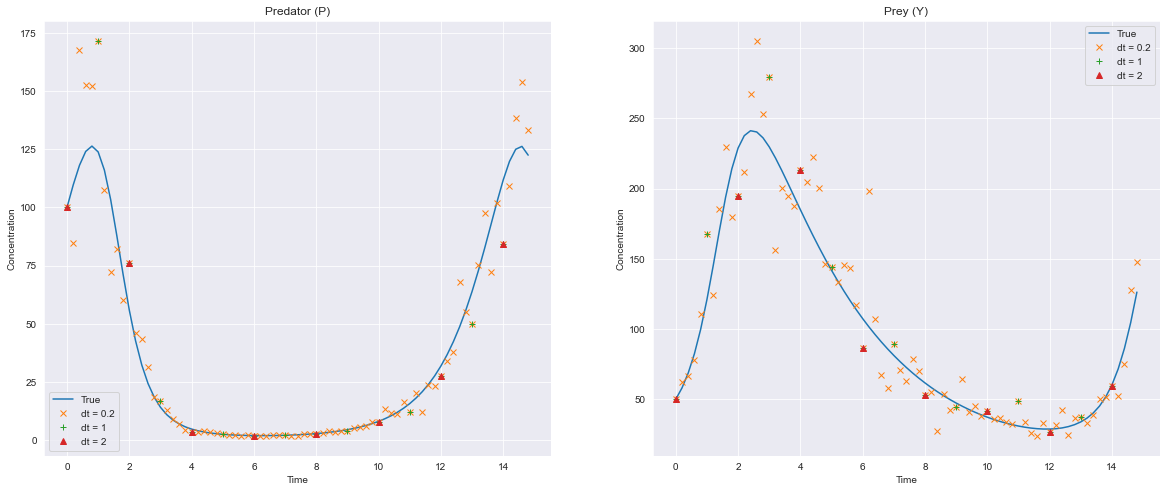

In [373]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(t, Z_obs[:,0], color = 'C0', label = 'True')
ax[1].plot(t, Z_obs[:,1], color = 'C0', label = 'True')
ax[0].plot(t, Z_obs_noisy[:,0], 'x', color = 'C1', label = 'dt = 0.2')
ax[1].plot(t, Z_obs_noisy[:,1], 'x', color = 'C1', label = 'dt = 0.2')
ax[0].plot(t_1, Z_obs_noisy_1[:,0], '+', color = 'C2', label = 'dt = 1')
ax[1].plot(t_1, Z_obs_noisy_1[:,1], '+', color = 'C2', label = 'dt = 1')
ax[0].plot(t_2, Z_obs_noisy_2[:,0], '^', color = 'C3', label = 'dt = 2')
ax[1].plot(t_2, Z_obs_noisy_2[:,1], '^', color = 'C3', label = 'dt = 2')
ax[0].legend()
ax[1].legend()

ax[1].set_title("Prey (Y)")
ax[0].set_title("Predator (P)")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Concentration")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Concentration")
fig.set_size_inches(20,8)
plt.savefig("results/figs/lk_obs.png", dpi = 400)

### Plotting Observations

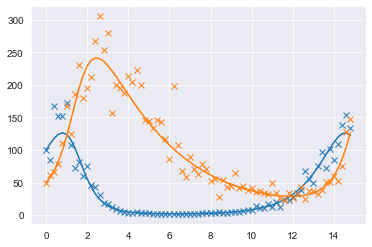

In [5]:
fig, ax = plt.subplots()
ax.plot(t, Z_obs[:,0], color = 'C0', label = 'Prey')
ax.plot(t, Z_obs[:,1], color = 'C1', label = 'Predator')
ax.plot(t, Z_obs_noisy[:,0], 'x', color = 'C0')
ax.plot(t, Z_obs_noisy[:,1], 'x', color = 'C1')

## Latent-Variable with Horseshoe Prior

In [258]:
bs_horseshoe = RSINDyRegularizedHorseshoe(species_names, custom_reaction_basis)

In [259]:
tests = [(2, t_2, Z_obs_noisy_2), (1, t_1, Z_obs_noisy_1), (0.2, t, Z_obs_noisy)]
fits = []
for dt, ts, Zs in tests:
    fit, _, S, R, D = bs_horseshoe.fit_non_dx(
        X0 = Zs[0,:],
        X_obs = Zs[1:,:],
        ts = ts,
        known_S = None,
        known_R = None,
        known_rates = [],
        regularized = True,
        N = 16,
        model_params = {
            'm0' : 3,
            'slab_scale' : 4,
            'slab_df' : 4,
            'tau0' : 1e-8,
            'noise_sigma' : 0.2,
        },
        fit_params = {
            'chains' : 1,
            'iter_warmup' : 2000,
            'iter_sampling' : 1000,
            'show_progress' : 'notebook',
            'prior_predictive' : False
        },
        shuffle = False)
    fits.append((fit, S, R, D))

Chain 1 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:cmdstanpy:compiling stan program, exe file: /private/var/folders/fr/mndzyyfj3077yvc2kyyr2l2r0000gn/T/tmpum7vmtj3
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /private/var/folders/fr/mndzyyfj3077yvc2kyyr2l2r0000gn/T/tmpum7vmtj3


Chain 1 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:cmdstanpy:compiling stan program, exe file: /private/var/folders/fr/mndzyyfj3077yvc2kyyr2l2r0000gn/T/tmphy6n48j_
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /private/var/folders/fr/mndzyyfj3077yvc2kyyr2l2r0000gn/T/tmphy6n48j_


Chain 1 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

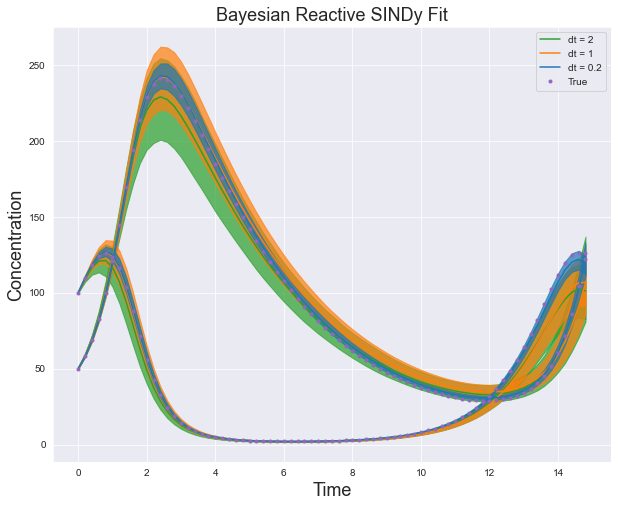

In [260]:
fig, ax = plt.subplots()
labels = ["dt = 2", "dt = 1", "dt = 0.2"]
species_names = ['P', 'Y']
for j, fit_f in enumerate(fits):
    fit, S, R, D = fit_f
    samples = fit.stan_variables()['rates']
    all_infs = []
    for i in range(samples.shape[0]):
        Z_est = solve_estimated_dynamics(samples[i,:], S, R, [100, 50], t)
        all_infs.append(Z_est)
    
    all_infs = np.stack(all_infs)
    pct_20 = np.percentile(all_infs, 5, axis = 0)
    pct_50 = np.percentile(all_infs, 50, axis = 0)
    pct_80 = np.percentile(all_infs, 95, axis = 0)
    for k in range(2):
        if k == 1:
            ax.plot(t, pct_50[:,k], color = 'C%d' % (2 - j), alpha = 1, label = labels[j])
        else:
            ax.plot(t, pct_50[:,k], color = 'C%d' % (2 - j), alpha = 1)
        ax.fill_between(t, pct_20[:,k], pct_80[:,k], color = 'C%d' % (2 - j), alpha = 0.7)
        
ax.set_title("Bayesian Reactive SINDy Fit", fontsize = 18)
ax.set_xlabel("Time", fontsize = 18)
ax.set_ylabel("Concentration", fontsize = 18)
for k in range(2):
    if k == 1:
        ax.plot(t, Z_obs[:,k], '.', color = 'C4', label = 'True', alpha = 1)
    else:
        ax.plot(t, Z_obs[:,k], '.', color = 'C4', alpha = 1)
    ax.legend()
fig.set_size_inches(10, 8)

## RSINDy Fit

In [357]:
Zrs = []
tests2 = [(2, t_2, Z_obs_noisy_2), (1, t_1, Z_obs_noisy_1), (0.2, t, Z_obs_noisy), (0.2, t, Z_obs)]
best_estimated_rates = []
for dt, ts, Zs in tests2:
    pp.TIMESTEP = ts[1] - ts[0]
    dcounts_dt_z_obs = pp.interp_deriv(ts, Zs)
    result_gridsolve = pp.solve_grid(counts=Zs, dcounts_dt=dcounts_dt_z_obs, alphas=np.logspace(-5, -2, num=1000), 
                                 l1_ratios=1, njobs=1)
    alphas_gs = np.array([res[0] for res in result_gridsolve])
    sort = np.argsort(alphas_gs)
    alphas_gs = alphas_gs[sort]
    estimated_rates_gs = np.array([res[2] for res in result_gridsolve])
    estimated_rates_gs = estimated_rates_gs[sort]
    l1_errs_gs = np.sum(np.abs(estimated_rates_gs - pp.RATES), axis=1)
    best_estimated_rates_gs = estimated_rates_gs[np.argmin(l1_errs_gs)]
    Z_est = solve_estimated_dynamics(best_estimated_rates_gs, fits[0][1], fits[0][2], [100, 50], t)
    best_estimated_rates.append(best_estimated_rates_gs)
    Zrs.append(Z_est)

Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1e-05, lambda=1)!
status 0: Optimization terminated successfully
28 / 30000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.0069386314760271e-05, lambda=1)!
status 0: Optimization terminated successfully
24 / 30000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.0139254075588143e-05, lambda=1)!
status 0: Optimization terminated successfully
26 / 30000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.0209606623060476e-05, lambda=1)!
status 0: Optimization terminated successfully
17 / 30000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.0280447320933097e-05, lambda=1)!
status 0: Optimization terminated successfully
19 / 30000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.0351779556301762e-05, lambda=1)!
status 0: Optimization t

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)




status 0: Optimization terminated successfully
18 / 30000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.0003065395295056527, lambda=1)!
status 0: Optimization terminated successfully
27 / 30000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.00030866649433372746, lambda=1)!
status 0: Optimization terminated successfully
17 / 30000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.00031080821738690636, lambda=1)!
status 0: Optimization terminated successfully
10 / 30000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.000312964801067075, lambda=1)!
status 0: Optimization terminated successfully
13 / 30000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.00031513634848664794, lambda=1)!
status 0: Optimization terminated successfully
19 / 30000 iterations
Trying tolerance 1e-16
optimization problem did 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



optimization problem did exit successfully (alpha=0.007126115430111745, lambda=1)!
status 0: Optimization terminated successfully
23 / 30000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.007175560918936928, lambda=1)!
status 0: Optimization terminated successfully
20 / 30000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.007225349491787214, lambda=1)!
status 0: Optimization terminated successfully
26 / 30000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.007275483529196225, lambda=1)!
status 0: Optimization terminated successfully
21 / 30000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.00732596542821523, lambda=1)!
status 0: Optimization terminated successfully
24 / 30000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.007376797602527731, lambda=1)!
status 0: Optimization terminated successfu

Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1e-05, lambda=1)!
status 0: Optimization terminated successfully
15 / 30000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.0069386314760271e-05, lambda=1)!
status 0: Optimization terminated successfully
12 / 30000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.0139254075588143e-05, lambda=1)!
status 0: Optimization terminated successfully
19 / 30000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.0209606623060476e-05, lambda=1)!
status 0: Optimization terminated successfully
11 / 30000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.0280447320933097e-05, lambda=1)!
status 0: Optimization terminated successfully
12 / 30000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.0351779556301762e-05, lambda=1)!
status 0: Optimization t

Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1e-05, lambda=1)!
status 0: Optimization terminated successfully
9 / 30000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.0069386314760271e-05, lambda=1)!
status 0: Optimization terminated successfully
10 / 30000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.0139254075588143e-05, lambda=1)!
status 0: Optimization terminated successfully
18 / 30000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.0209606623060476e-05, lambda=1)!
status 0: Optimization terminated successfully
18 / 30000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.0280447320933097e-05, lambda=1)!
status 0: Optimization terminated successfully
14 / 30000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.0351779556301762e-05, lambda=1)!
status 0: Optimization te

Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1e-05, lambda=1)!
status 0: Optimization terminated successfully
20 / 30000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.0069386314760271e-05, lambda=1)!
status 0: Optimization terminated successfully
17 / 30000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.0139254075588143e-05, lambda=1)!
status 0: Optimization terminated successfully
25 / 30000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.0209606623060476e-05, lambda=1)!
status 0: Optimization terminated successfully
17 / 30000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.0280447320933097e-05, lambda=1)!
status 0: Optimization terminated successfully
9 / 30000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.0351779556301762e-05, lambda=1)!
status 0: Optimization te

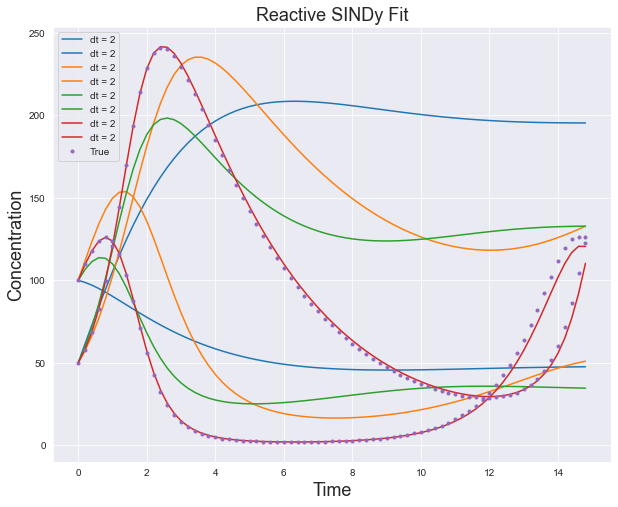

In [141]:
fig, ax = plt.subplots()
labels = ["dt = 2", "dt = 1", "dt = 0.2", "dt = 0.2 (noiseless)"]
ax.set_title("Reactive SINDy Fit", fontsize = 18)
ax.set_xlabel("Time", fontsize = 18)
ax.set_ylabel("Concentration", fontsize = 18)
for i in range(len(Zrs)):
    ax.plot(t, Zrs[i][:,0], color = 'C%d' % i, label = labels[0])
    ax.plot(t, Zrs[i][:,1], color = 'C%d' % i, label = labels[0])
for k in range(2):
    if k == 1:
        ax.plot(t, Z_obs[:,k], '.', color = 'C4', label = 'True', alpha = 1)
    else:
        ax.plot(t, Z_obs[:,k], '.', color = 'C4', alpha = 1)
    ax.legend()
fig.set_size_inches(10, 8)

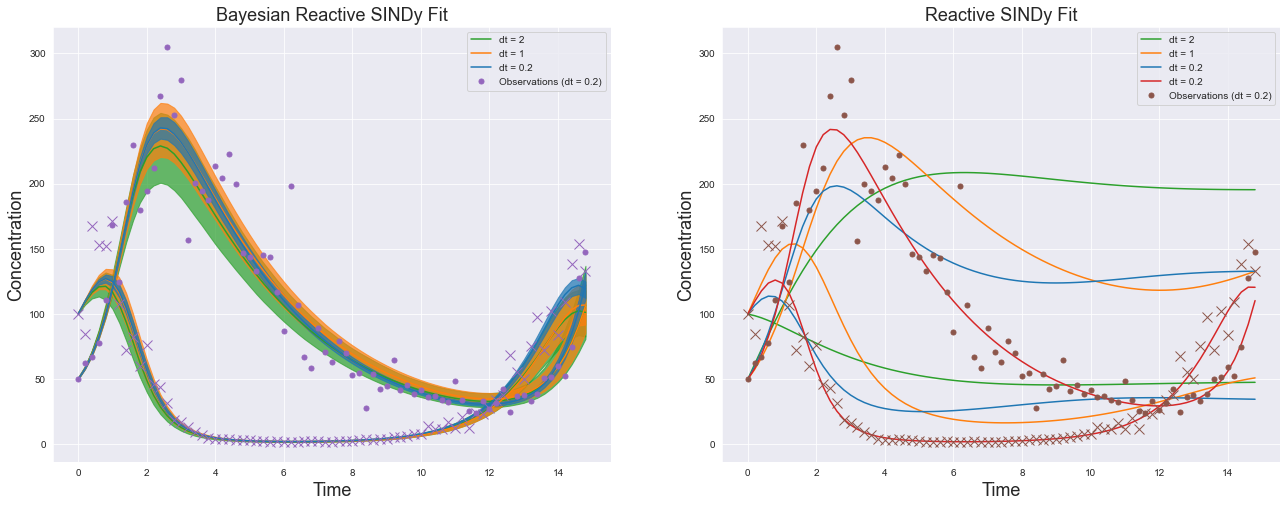

In [375]:
fig, ax = plt.subplots(1, 2)
labels = ["dt = 2", "dt = 1", "dt = 0.2"]
species_names = ['P', 'Y']
for j, fit_f in enumerate(fits):
    fit, S, R, D = fit_f
    samples = fit.stan_variables()['rates']
    all_infs = []
    for i in range(samples.shape[0]):
        Z_est = solve_estimated_dynamics(samples[i,:], S, R, [100, 50], t)
        all_infs.append(Z_est)
    
    all_infs = np.stack(all_infs)
    pct_20 = np.percentile(all_infs, 5, axis = 0)
    pct_50 = np.percentile(all_infs, 50, axis = 0)
    pct_80 = np.percentile(all_infs, 95, axis = 0)
    for k in range(2):
        if k == 1:
            ax[0].plot(t, pct_50[:,k], color = 'C%d' % (2 - j), alpha = 1, label = labels[j])
        else:
            ax[0].plot(t, pct_50[:,k], color = 'C%d' % (2 - j), alpha = 1)
        ax[0].fill_between(t, pct_20[:,k], pct_80[:,k], color = 'C%d' % (2 - j), alpha = 0.7)
ax[0].legend()     
ax[0].set_title("Bayesian Reactive SINDy Fit", fontsize = 18)
ax[0].set_xlabel("Time", fontsize = 18)
ax[0].set_ylabel("Concentration", fontsize = 18)
for k in range(2):
    if k == 1:
        ax[0].plot(t, Z_obs_noisy[:,k], '.', color = 'C4', markersize = 10, label = 'Observations (dt = 0.2)', alpha = 1)
    else:
        ax[0].plot(t, Z_obs_noisy[:,k], 'x', color = 'C4', markersize = 10, alpha = 1)
ax[0].legend()

labels = ["dt = 2", "dt = 1", "dt = 0.2"]
ax[1].set_title("Reactive SINDy Fit", fontsize = 18)
ax[1].set_xlabel("Time", fontsize = 18)
ax[1].set_ylabel("Concentration", fontsize = 18)
for i in range(len(labels)):
    ax[1].plot(t, Zrs[i][:,0], color = 'C%d' % (2 - i), label = labels[i])
    ax[1].plot(t, Zrs[i][:,1], color = 'C%d' % (2 - i))

ax[1].plot(t, Zrs[3][:,0], color = 'C3', label = labels[i])
ax[1].plot(t, Zrs[3][:,1], color = 'C3')    
    
for k in range(2):
    if k == 1:
        ax[1].plot(t, Z_obs_noisy[:,k], '.', color = 'C5', markersize = 10, label = 'Observations (dt = 0.2)', alpha = 1)
    else:
        ax[1].plot(t, Z_obs_noisy[:,k], 'x', color = 'C5', markersize = 10, alpha = 1)
    ax[1].legend()
        
fig.set_size_inches(22, 8)
plt.savefig("results/figs/lv_fits.png", dpi = 400)

In [281]:
probs, reactions = prune_reactions(fits[1][0])

### Partial Observation of Species

In [294]:
fit_partial, _, Sp, Rp, Dp = bs_horseshoe.fit_non_dx(
    X0 = Z_obs_noisy_1[0,:],
    X_obs = Z_obs_noisy_1[1:,1:2],
    ts = t_1,
    known_S = None,
    known_R = None,
    observed_species = ['Y'],
    known_rates = [],
    regularized = True,
    N = 16,
    model_params = {
        'm0' : 3,
        'slab_scale' : 2,
        'slab_df' : 2,
        'tau0' : 1e-8,
        'noise_sigma' : 0.2,
    },
    fit_params = {
        'chains' : 4,
        'iter_warmup' : 2000,
        'iter_sampling' : 1000,
        'show_progress' : 'notebook',
        'prior_predictive' : False
    },
shuffle = False)

Chain 1 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 3 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 4 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

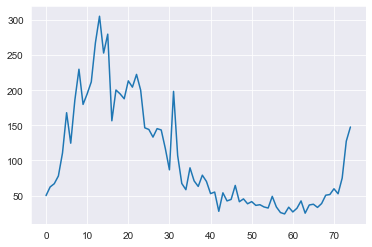

In [371]:
plt.plot(Z_obs_noisy[:,1:2])

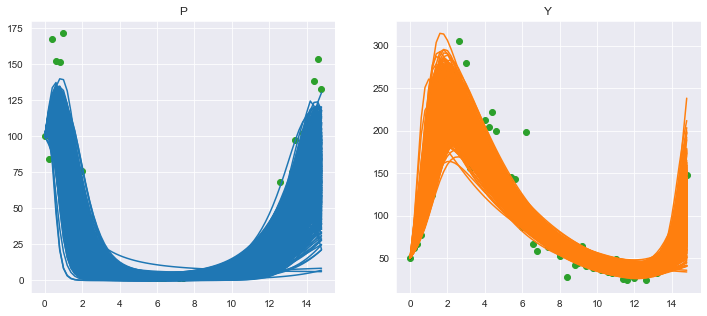

In [300]:
rates = fit_partial.stan_variables()['rates'][3000:4000]
fig = bs_horseshoe.plot_simulated_trajectories(rates, S, R, [100, 50], t)
fig.set_size_inches(12, 5)
fig.axes[0].scatter(t, Z_obs_noisy[:,0], color = 'C2')
fig.axes[1].scatter(t, Z_obs_noisy[:,1], color = 'C2')

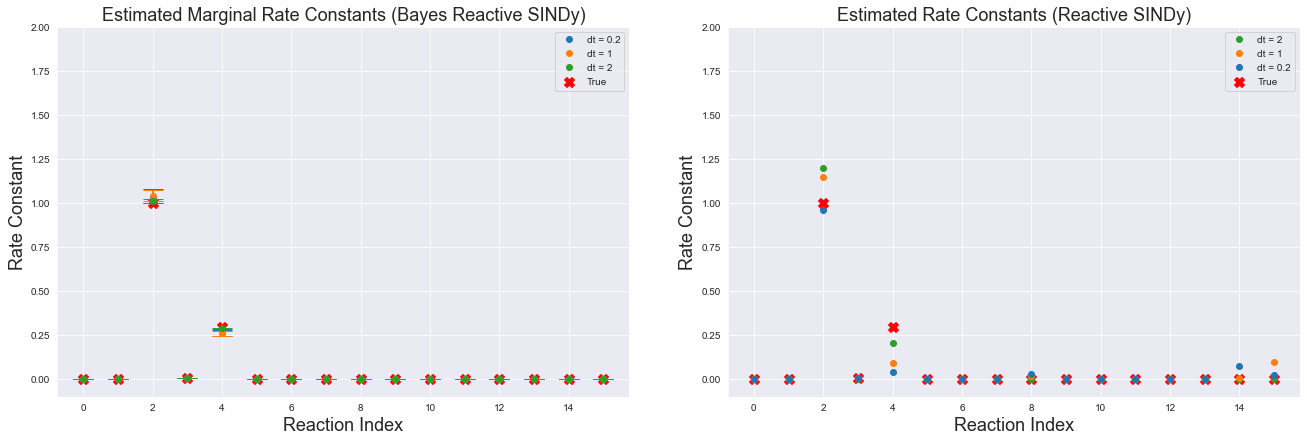

In [369]:
fig = plt.figure(constrained_layout=True, figsize=(20, 8))
subfigs = fig.subfigures(1, 2, wspace=0.07)
axl = subfigs[0].subplots()

labels = ["dt = 0.2", "dt = 1", "dt = 2"]
for i, fit in enumerate(fits):
    rates = fit[0].stan_variables()['rates']
    pct_20 = np.percentile(rates, 20, axis = 0)
    pct_50 = np.percentile(rates, 50, axis = 0)
    pct_80 = np.percentile(rates, 80, axis = 0)
    
    axl.plot(np.arange(0,16,1), pct_50,'o', color = 'C%d' % i, label = labels[i])
    axl.errorbar(np.arange(0,16,1), pct_50, fmt = 'none', capsize = 10, color = 'C%d' % i, yerr = [pct_50 - pct_20, pct_80 - pct_50])

axl.set_ylim([-0.1, 2])
x_true = np.arange(0,16,1)
y_true = np.zeros(16)
y_true[2] = 1.0
y_true[3] = 0.01
y_true[4] = 0.3
axl.scatter(x_true, y_true, s = 100, marker = 'X', color = 'red', label = 'True')

axl.legend()
axl.set_title("Estimated Marginal Rate Constants (Bayes Reactive SINDy)", fontsize = 18)
axl.set_xlabel("Reaction Index", fontsize = 18)
axl.set_ylabel("Rate Constant", fontsize = 18)

axr = subfigs[1].subplots()

labels = ["dt = 0.2", "dt = 1", "dt = 2"]
for i in range(3):
    axr.plot(np.arange(0,16,1), best_estimated_rates[i],'o', color = 'C%d' % (2 - i), label = labels[2 - i])

axr.set_ylim([-0.1, 2])
x_true = np.arange(0,16,1)
y_true = np.zeros(16)
y_true[2] = 1.0
y_true[3] = 0.01
y_true[4] = 0.3
axr.scatter(x_true, y_true, s = 100, marker = 'X', color = 'red', label = 'True')

axr.legend()
axr.set_title("Estimated Rate Constants (Reactive SINDy)", fontsize = 18)
axr.set_xlabel("Reaction Index", fontsize = 18)
axr.set_ylabel("Rate Constant", fontsize = 18)

fig.set_size_inches(18, 6)
plt.savefig("results/figs/estiamted_parameters.png", dpi = 400)

['2X -> 0',
 '2Y -> 0',
 'X -> 2X',
 'X + Y -> 2Y',
 'Y -> 0',
 'X + Y -> 2X',
 'X -> 0',
 '2Y -> Y',
 'Y -> 2Y',
 '2X -> X',
 'X + Y -> X',
 'X + Y -> Y',
 '2X -> Y',
 'X -> Y',
 'Y -> X',
 'X -> 2Y']